# Use SARSA to Play MoutainCar-v0

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('MountainCar-v0', new_step_api=True)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

15:06:49 [INFO] env: <MountainCarEnv<MountainCar-v0>>
15:06:49 [INFO] action_space: Discrete(3)
15:06:49 [INFO] observation_space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
15:06:49 [INFO] reward_range: (-inf, inf)
15:06:49 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
15:06:49 [INFO] _max_episode_steps: 200
15:06:49 [INFO] _elapsed_steps: None
15:06:49 [INFO] id: MountainCar-v0
15:06:49 [INFO] entry_point: gym.envs.classic_control:MountainCarEnv
15:06:49 [INFO] reward_threshold: -110.0
15:06:49 [INFO] nondeterministic: False
15:06:49 [INFO] max_episode_steps: 200
15:06:49 [INFO] _kwargs: {}
15:06:49 [INFO] _env_name: MountainCar


In [3]:
class TileCoder:
    def __init__(self, layer_count, feature_count):
        self.layer_count = layer_count
        self.feature_count = feature_count
        self.codebook = {}

    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count = len(self.codebook)
        if count >= self.feature_count:  # resolve conflicts
            return hash(codeword) % self.feature_count
        self.codebook[codeword] = count
        return count

    def __call__(self, floats=(), ints=()):
        dim = len(floats)
        scaled_floats = tuple(f * (self.layer_count ** 2) for f in floats)
        features = []
        for layer in range(self.layer_count):
            codeword = (layer,) + tuple(
                    int((f + (1 + dim * i) * layer) / self.layer_count)
                    for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

In [4]:
class SARSAAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - \
                env.observation_space.low
        self.encoder = TileCoder(8, 1896)
        self.w = np.zeros(self.encoder.feature_count)
        self.gamma = 1.
        self.learning_rate = 0.03

    def encode(self, observation, action):
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)

    def get_q(self, observation, action):  # action value
        features = self.encode(observation, action)
        return self.w[features].sum()

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, termination):
        if self.mode == 'train' and np.random.rand() < 0.001:
            action = np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in
                    range(self.action_n)]
            action = np.argmax(qs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, termination, action]
            if len(self.trajectory) >= 8:
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        observation, _, _, action, next_observation, reward, termination, \
                next_action = self.trajectory[-8:]
        target = reward + (1. - termination) * self.gamma * \
                self.get_q(next_observation, next_action)
        td_error = target - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += (self.learning_rate * td_error)


agent = SARSAAgent(env)

15:06:49 [INFO] ==== train ====
15:06:49 [INFO] train episode 0: reward = -200.00, steps = 200
15:06:50 [INFO] train episode 1: reward = -200.00, steps = 200
15:06:50 [INFO] train episode 2: reward = -200.00, steps = 200
15:06:50 [INFO] train episode 3: reward = -200.00, steps = 200
15:06:50 [INFO] train episode 4: reward = -200.00, steps = 200
15:06:50 [INFO] train episode 5: reward = -200.00, steps = 200
15:06:50 [INFO] train episode 6: reward = -200.00, steps = 200
15:06:51 [INFO] train episode 7: reward = -200.00, steps = 200
15:06:51 [INFO] train episode 8: reward = -200.00, steps = 200
15:06:51 [INFO] train episode 9: reward = -200.00, steps = 200
15:06:51 [INFO] train episode 10: reward = -200.00, steps = 200
15:06:51 [INFO] train episode 11: reward = -200.00, steps = 200
15:06:52 [INFO] train episode 12: reward = -200.00, steps = 200
15:06:52 [INFO] train episode 13: reward = -200.00, steps = 200
15:06:52 [INFO] train episode 14: reward = -200.00, steps = 200
15:06:52 [INFO] tr

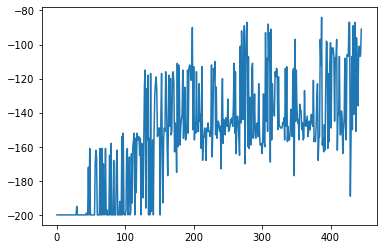

In [5]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation = env.reset(seed=seed)
    reward, termination, truncation = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, termination)
        if render:
            env.render()
        if termination or truncation:
            break
        observation, reward, termination, truncation, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode,
            mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -110:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()